# Imports / installations

In [1]:
# Do not forget to check if your notebook log collection plugin is working
from mining_extension import check_logging
check_logging("http://3.249.245.244:9999")

Request successful!


In [2]:
!pip install pandas

In [3]:
!pip install numpy

In [4]:
!pip install seaborn

In [5]:
!pip install scipy

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd
import seaborn as sns
import zipfile

# Data Engineering

In [7]:
# Reading the data from a text file and saving to Pandas DataFrame
with zipfile.ZipFile('data/task1/jetnet_logs.zip') as myzip:
    with myzip.open('jetnet_logs.txt') as myfile:
        df = pd.read_csv(myfile, delimiter='\t', header=None)

In [8]:
# Looking at the raw data
df.head()

,0
0,@User92: Action_3 (15/10/19 | 18:08:02) -> Act...
1,@User140: Action_3 (15/05/20 | 15:37:04) -> Ac...
2,@User105: Action_4 (25/04/20 | 01:08:29) -> Ac...
3,@User127: Action_1 (20/06/20 | 00:24:48) -> Ac...
4,@User50: Action_4 (09/10/19 | 15:12:52) --> Ac...


In [9]:
# For each instance separate the user and their list of actions
df['user_id'] = df[0].str.split(':').str[0]
df['info'] = df[0].str.split(': ').str[1]
df['user_id'] = df['user_id'].str.replace('@', '')
df = df.drop(0, axis=1)

In [10]:
# Making list of actions with corresponding user info
df = df.assign(actions=df['info'].str.split('>')).explode('actions')
df['actions'] = df['actions'].str.strip('-')
df = df.drop('info', axis=1)
df = df.reset_index(drop=True)

In [11]:
df['action_time'] = df['actions'].str.split(n=1).str[1]
df['action_time'] = df['action_time'].str.strip(' ')
df['action_name'] = df['actions'].str.split().str.get(0)
df = df.drop('actions', axis=1)

In [12]:
df['action_time'] = pd.to_datetime(df['action_time'], format='(%d/%m/%y | %H:%M:%S)', errors='coerce')
df = df.sort_values(['user_id', 'action_time'])
df.dropna(how='any', inplace=True)

In [13]:
df['session_num'] = (df['action_name'] == 'END').groupby(df['user_id']).cumsum()

In [14]:
df = df[df['action_name'] != 'END']
df = df[df['action_name'] != 'null']
df.dropna(how='any', inplace=True)
df = df.reset_index(drop=True)

In [15]:
# The resulting dataset is as follows
df

,user_id,action_time,action_name,session_num
0,User0,2019-09-21 15:51:54,Action_10,0
1,User0,2019-09-21 15:54:18,Action_3,0
2,User0,2019-09-21 15:57:09,Action_4,0
3,User0,2019-09-21 16:05:32,Action_0,0
4,User0,2019-09-21 16:23:28,Action_4,0
...,...,...,...,...
1960900,User99,2021-09-10 05:11:20,Action_1,126
1960901,User99,2021-09-10 05:19:58,Action_3,126
1960902,User99,2021-09-10 05:39:00,Action_8,126
1960903,User99,2021-09-10 06:08:09,Action_4,127


We derived the needed dataframe, containing 'user_id', 'action_time', 'action_name' and 'session_num' columns.

# Metrics Evaluation

## Mean actions count per user overall

In [16]:
# Each user has different number of actions.
pd.DataFrame(df.groupby('user_id')['action_time'].count()).sample(n=10)

,action_time
user_id,
User21,4669
User14,5102
User63,9762
User107,21418
User3,18330
User132,3264
User9,21404
User114,17964
User15,5675


In [17]:
df.groupby('user_id')['action_time'].count().mean()

13712.622377622378

Average user made 13712.62 actions in the observed period.

## Mean actions by user in a day

In [18]:
df.groupby(['user_id', df['action_time'].dt.date]).size().mean()

28.491587237010346

Average user made about 28.5 actions per day in the observed period.

## Is there statistical difference of activity in different days of the week?

In [19]:
df['date'] = df['action_time'].dt.date
df['day_of_week'] = df['action_time'].dt.dayofweek

For testing statistical difference of activity in different days of the week we can use ANOVA test with H0 of no significant difference. We assume general things to use ANOVA ((1) interval data of the dependent variable, (2) normality, (3) homoscedasticity, and (4) no multicollinearity)

First we calculate the number of occurances for each day of the week.

In [20]:
data = pd.crosstab(df['day_of_week'], df.groupby(['day_of_week'])['date'].rank(method='dense').astype(int))
data

date,1,2,3,4,5,6,7,8,9,10,...,96,97,98,99,100,101,102,103,104,105
day_of_week,,,,,,,,,,,,,,,,,,,,,
0,2581,2293,2910,2712,2515,2792,2803,2911,2570,2661,...,2590,2263,2511,2682,2895,2726,2804,2668,2814,2
1,2777,2594,2518,2612,3145,2569,2547,2859,2580,2728,...,2749,2969,2816,2528,2889,2438,2645,2899,2621,0
2,3380,2426,2703,2391,2827,2881,2590,2399,2880,2457,...,2793,2879,2561,2513,2627,2799,2939,2529,2630,0
3,2377,2627,2750,2487,2526,2741,2812,2801,2814,3087,...,3068,2489,2859,2574,2501,2474,2616,2760,2592,0
4,936,2437,2347,2732,2314,2503,2719,2826,2883,2727,...,2602,2649,2480,3124,2379,2789,2755,2462,2783,2790
5,2935,2890,2758,2692,2277,2376,2614,2443,2998,2635,...,2696,2818,2631,2914,2823,2666,2517,2847,2500,2749
6,2741,2744,2743,2473,2953,2685,2370,3022,2844,2801,...,2632,2702,2473,2680,2577,3221,2729,2870,2461,2031


In [21]:
f_statistic, p_value = stats.f_oneway(data.iloc[0].to_list(),data.iloc[1].to_list(),data.iloc[2].to_list(),data.iloc[3].to_list(),data.iloc[4].to_list(),data.iloc[5].to_list(), data.iloc[6].to_list())

print("p-value:", p_value)

p-value: 0.6152486908733825


In this case, the p-value is rather big, so we cannot reject the null hypothesis that there is no significant difference between the means of the groups. This means that there is insufficient evidence to support the claim that the groups are different from one another.

To illustrate the test, we can plot the distribution among the days of the week.

<Axes: >

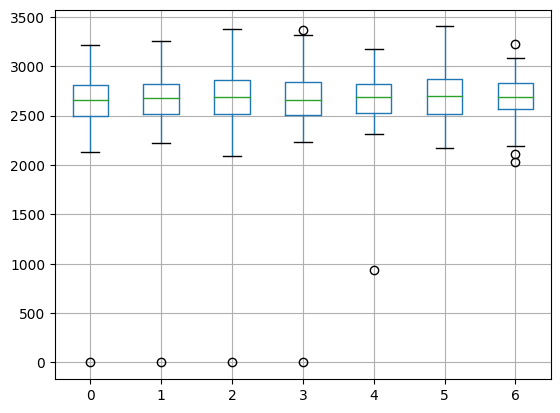

In [22]:
data.T.boxplot()

## And between weekends and workdays? 

We can use t-test, assuming homogeneity and normality. H0: the weekends and weekdays are statistically similar.

In [23]:
t_stat, p_val = stats.ttest_ind(data.iloc[0].to_list()+data.iloc[1].to_list()+data.iloc[2].to_list()+data.iloc[3].to_list()+data.iloc[4].to_list(),data.iloc[5].to_list()+data.iloc[6].to_list())
print("p-value:", p_val)

p-value: 0.19728675947892463


The p-value is great, so we cannot reject the null hypothesis that there is no significant difference between weekends and weekdays. For visualisation refer the plot above.

## Some additional metrics

Some additional mertics may include analyzing the duration of the sessions.

In [24]:
session_durations = df.groupby(['user_id', 'session_num'])['action_time'].apply(lambda x: x.max() - x.min())

mean_duration = session_durations.mean()
median_duration = session_durations.median()
mode_duration = session_durations.mode()[0]

print(f"Mean: {mean_duration}")
print(f"Median: {median_duration}")

Mean: 0 days 14:07:02.901683581
Median: 0 days 08:55:41


The average duration of the session is about 14 hours, 7 minutes while the median is a bit more than 8 hours 55 minutes.

# Data Visualisation

## the time series of count of different actions by days

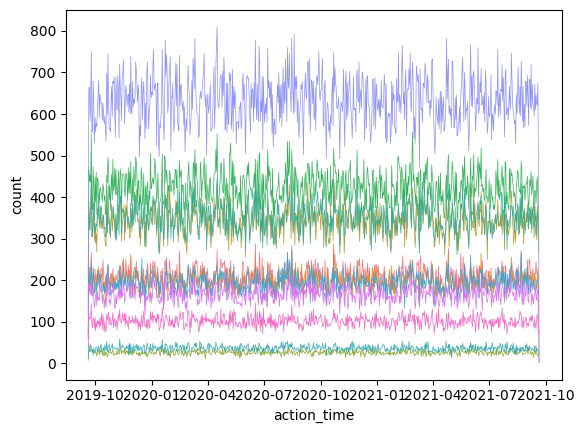

In [25]:
sns.lineplot(data=df.groupby([pd.Grouper(key='action_time', freq='D'), 'action_name']).size().reset_index(name='count'), x='action_time', y='count', hue='action_name', linewidth=0.5, legend=False)

plt.show()

The 'by day' plot is kinda noisy so instead we can try to visualise weekly action numbers.

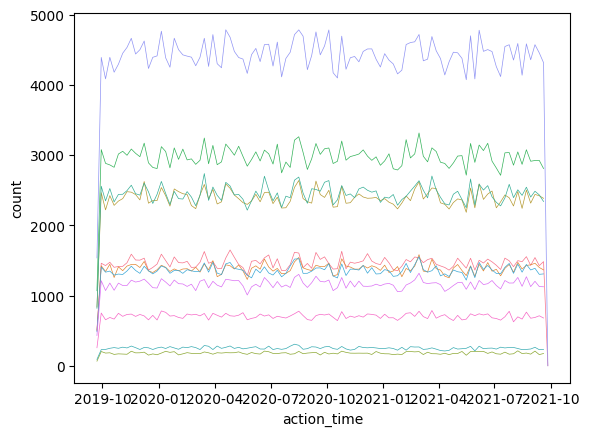

In [26]:
sns.lineplot(data=df.groupby([pd.Grouper(key='action_time', freq='W'), 'action_name']).size().reset_index(name='count'), x='action_time', y='count', hue='action_name', linewidth=0.5, legend=False)

plt.show()

## the barchart of different actions counts

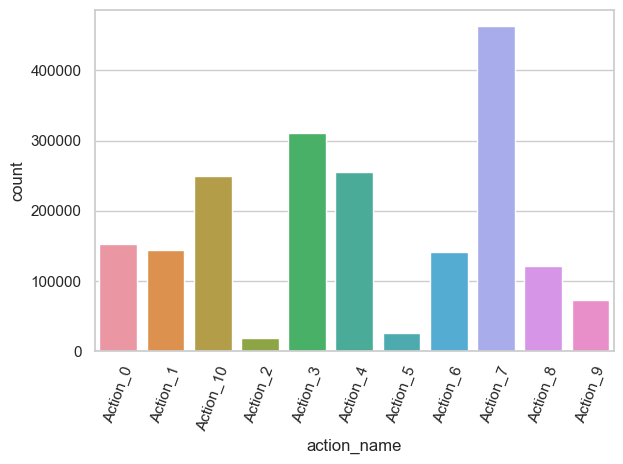

In [31]:
action_counts = df.groupby("action_name")["user_id"].count().reset_index(name="count")

sns.set(style="whitegrid")
sns.barplot(x="action_name", y="count", data=action_counts)
plt.xticks(rotation=70)
plt.tight_layout()
plt.show()

## the time series (line plot) of all actions of the top 20 percent of active users by days

In [33]:
user_daily_actions = df.groupby(['user_id', pd.Grouper(key='action_time', freq='D')])['action_name'].count().reset_index()
user_total_actions = user_daily_actions.groupby('user_id')['action_name'].sum().reset_index()
top_users = user_total_actions.nlargest(int(0.2*len(user_total_actions)), 'action_name')['user_id']

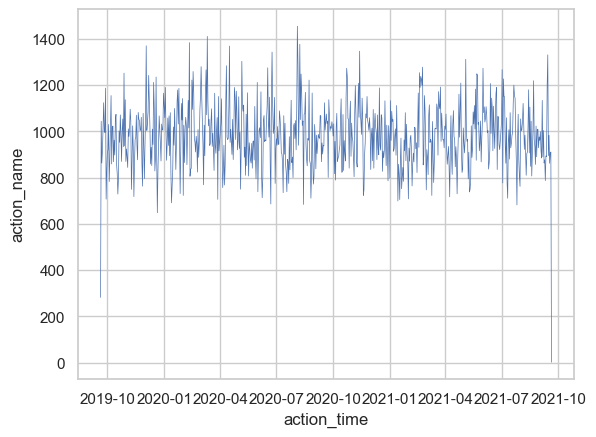

In [34]:
df_top_users = df[df['user_id'].isin(top_users)]

df_top_users = df_top_users.set_index('action_time')
daily_counts = df_top_users.resample('D').count()

sns.lineplot(data=daily_counts, x=daily_counts.index, y='action_name', linewidth=0.5, legend=False)

plt.show()

Again, noisy plot. We can redo it by week:

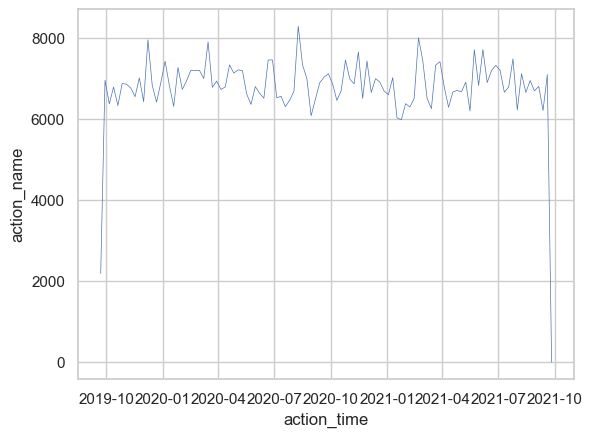

In [35]:
df_top_users = df[df['user_id'].isin(top_users)]

df_top_users = df_top_users.set_index('action_time')
daily_counts = df_top_users.resample('W').count()

sns.lineplot(data=daily_counts, x=daily_counts.index, y='action_name', linewidth=0.5, legend=False)

plt.show()

## Some additional plots

Session duration plot with different colors for each user.

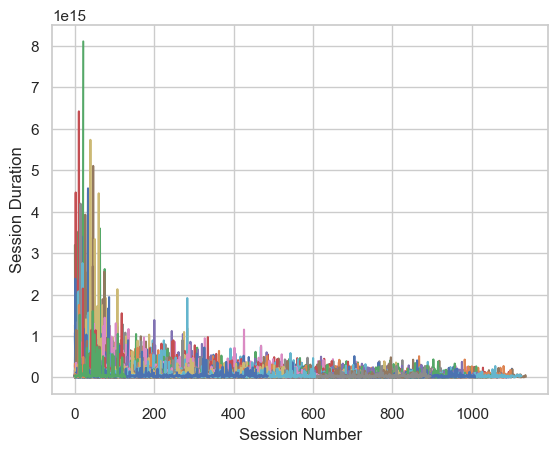

In [30]:
session_durations = df.groupby(['user_id', 'session_num'])['action_time'].agg(lambda x: x.max() - x.min())
fig, ax = plt.subplots()
for user_id in session_durations.index.get_level_values(0).unique():
    durations = session_durations[user_id]
    ax.plot(durations.index, durations)
ax.set_xlabel('Session Number')
ax.set_ylabel('Session Duration')
plt.show()